# VAR 

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## United States Macroeconomic Dataset 

In [3]:
macro_data = sm.datasets.macrodata.load_pandas()
macro_data = macro_data.data
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


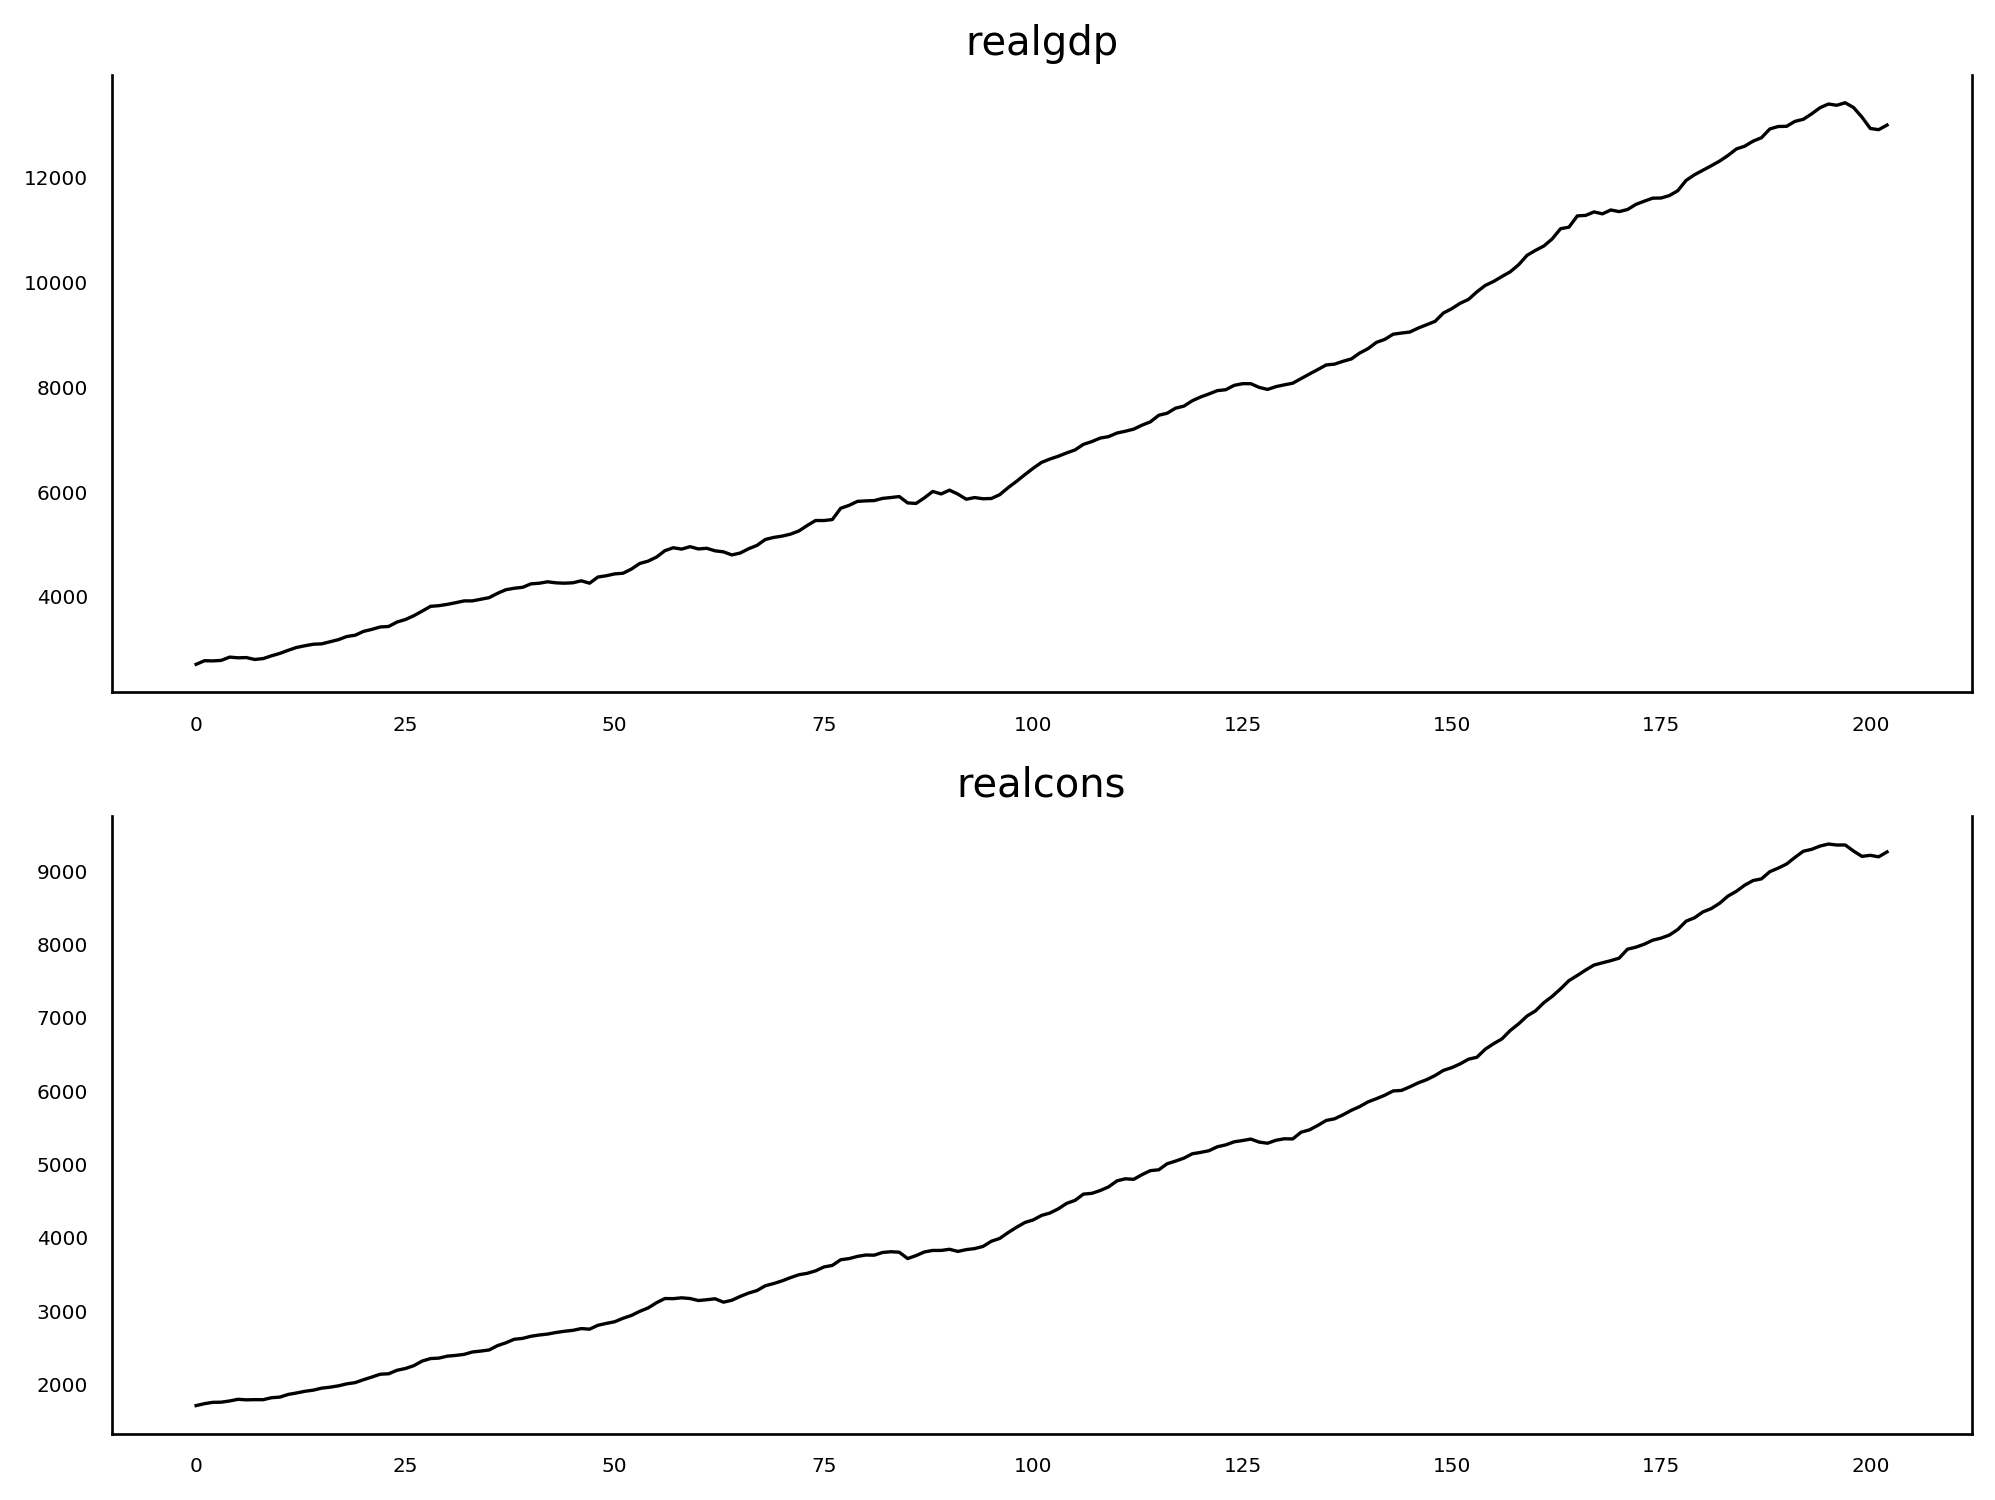

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

In [5]:
ad_fuller_result_1 = adfuller(macro_data['realgdp'].diff()[1:])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realgdp
ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08

---------------------

realcons
ADF Statistic: -4.204306080845246
p-value: 0.0006479282158627595


In [6]:
def optimize_VAR(endog):
    """
        Returns a dataframe with parameters and corresponding MSE
        
        endog - observed time series
    """
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        mse = model.mse
        results.append([i, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
endog = macro_data[['realgdp', 'realcons']]

result_df = optimize_VAR(endog)
result_df

In [8]:
best_model = VARMAX(endog, order=(12,0))
res = best_model.fit(disp=False)
print(res.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(12)   Log Likelihood               -1983.696
                               + intercept   AIC                           4073.392
Date:                     Wed, 17 Feb 2021   BIC                           4248.992
Time:                             16:47:07   HQIC                          4144.433
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.15, 0.14   Jarque-Bera (JB):          5.33, 10.13
Prob(Q):                        0.69, 0.71   Prob(JB):                   0.07, 0.01
Heteroskedasticity (H):         1.72, 2.56   Skew:                       0.3

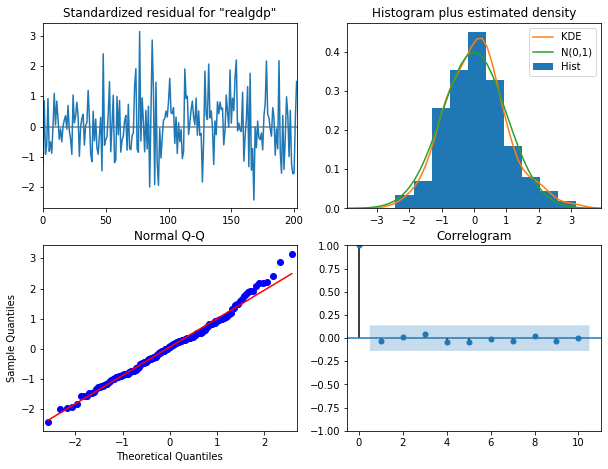

In [9]:
res.plot_diagnostics();

In [10]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)

,realgdp,realcons
204,13173.164998,9297.544770
205,13200.319368,9296.597230
206,13238.371474,9298.687583


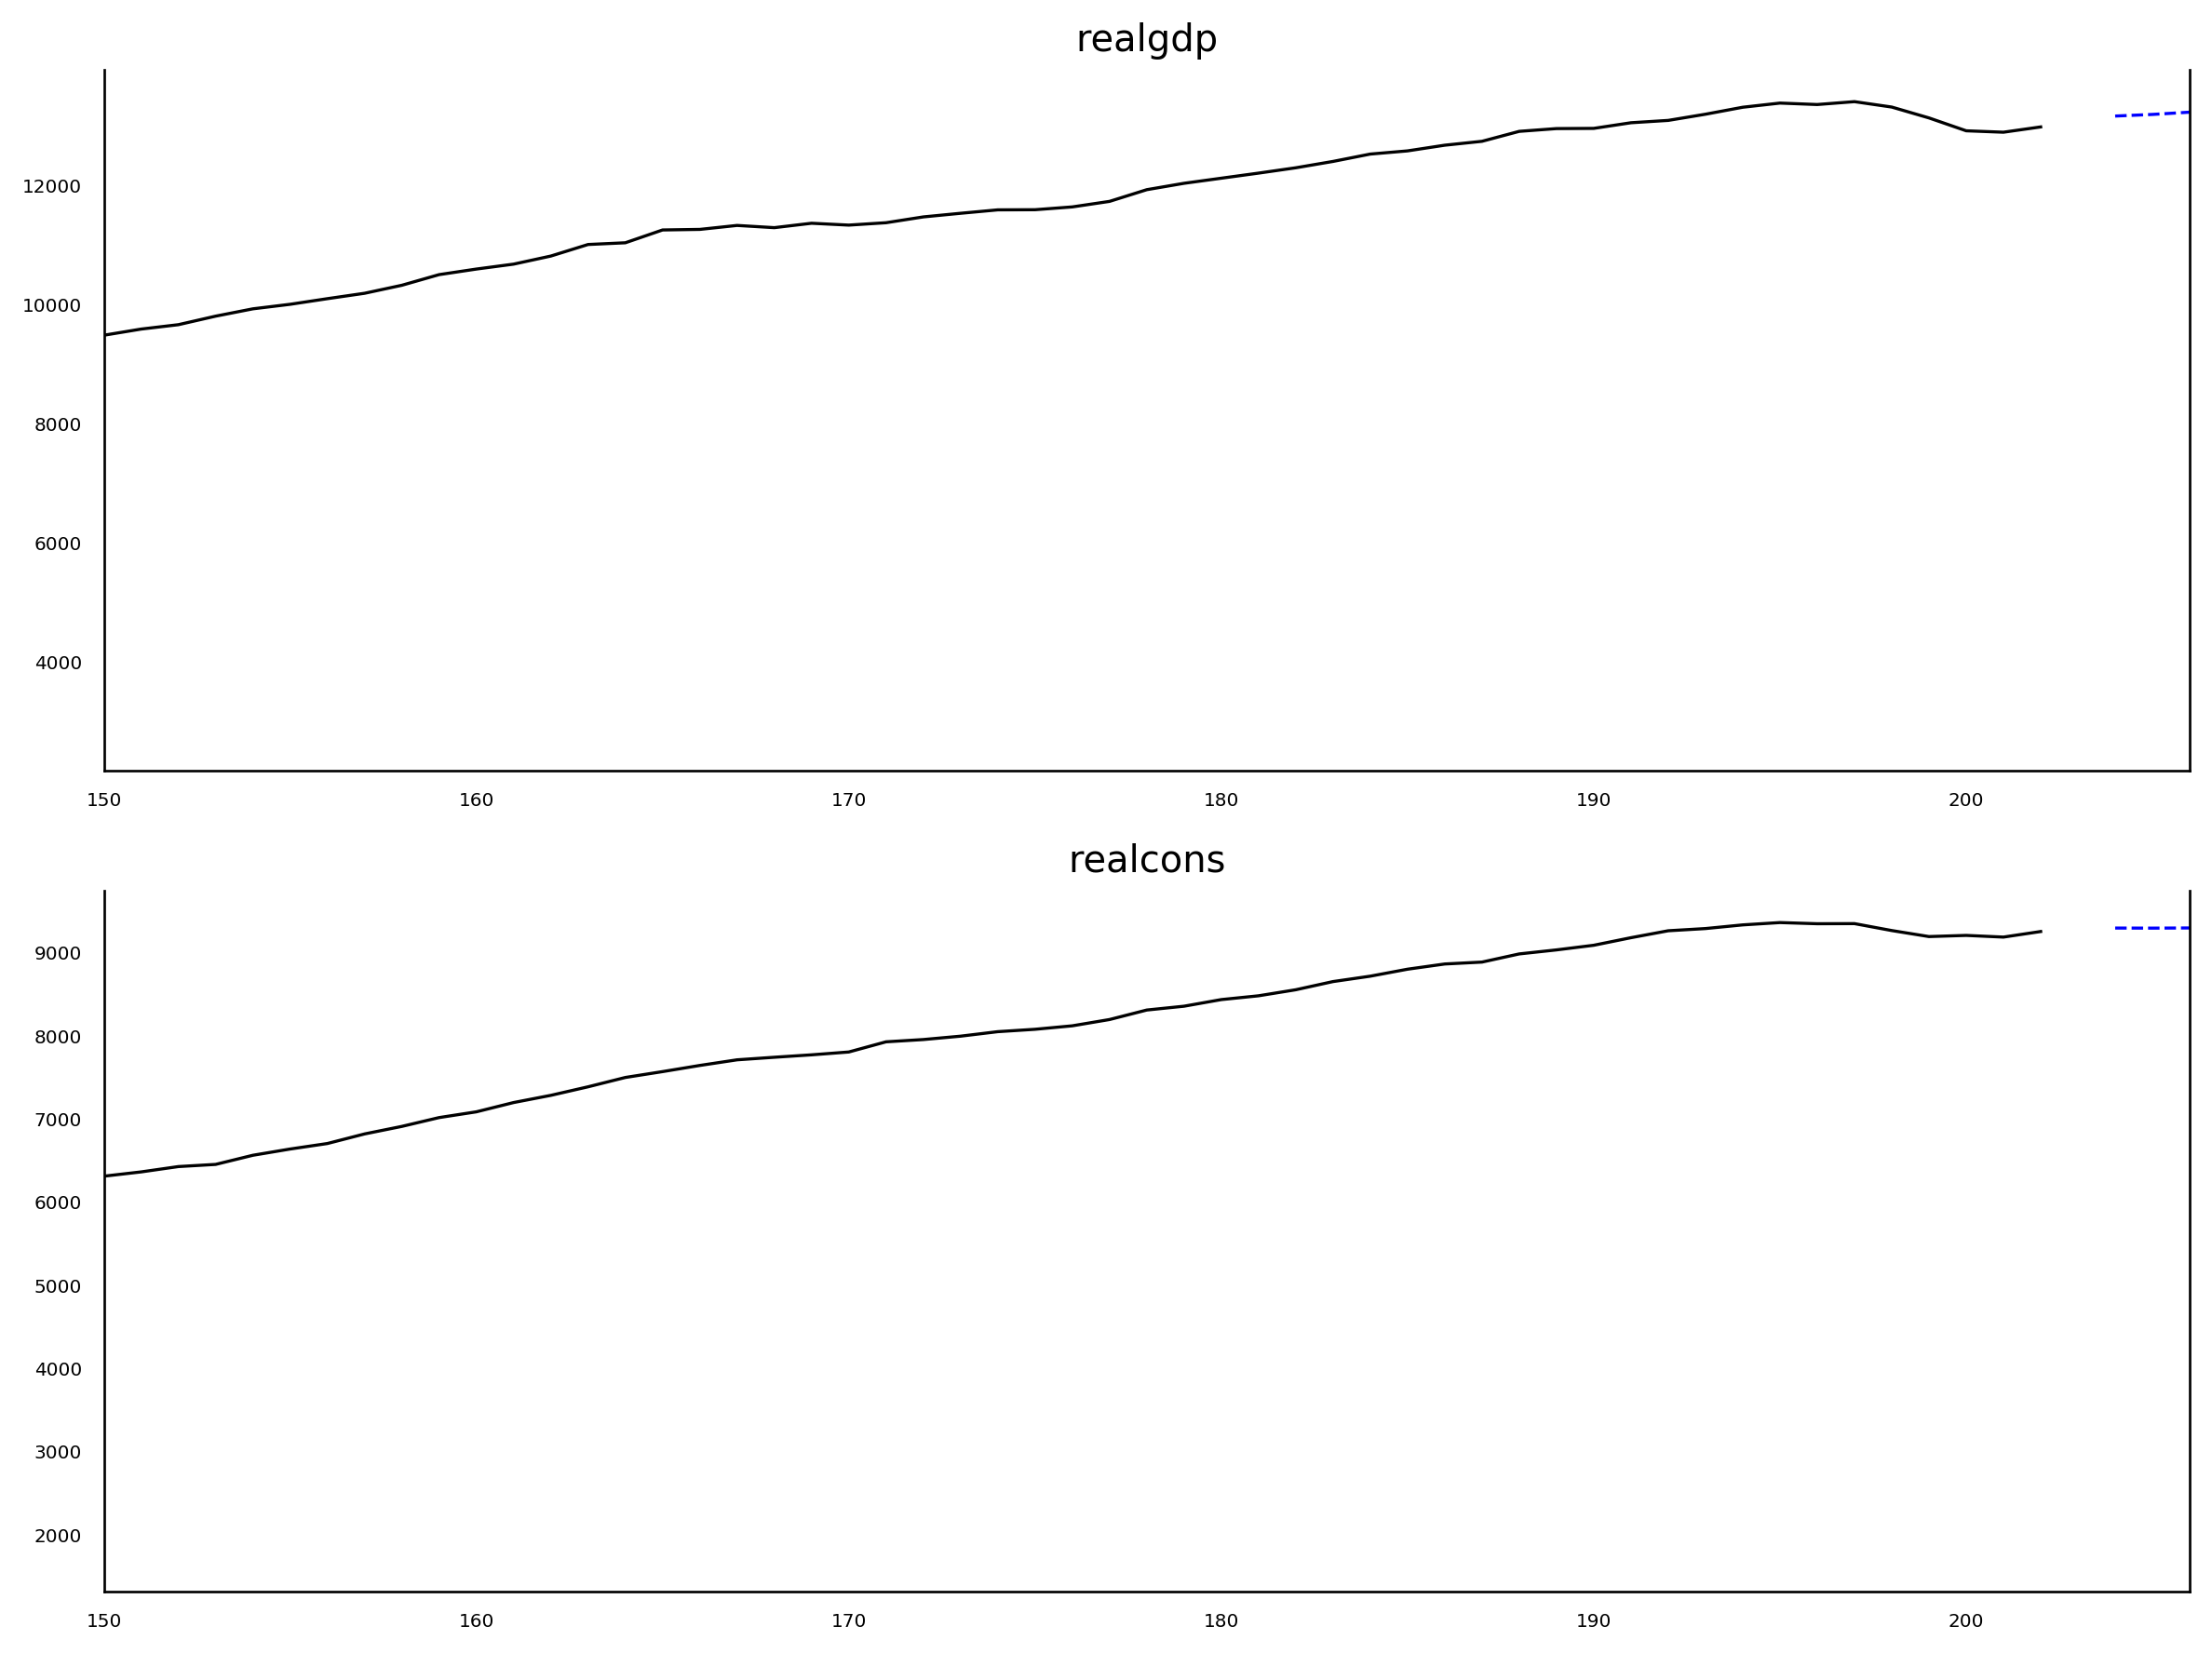

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:], 
         predict.predicted_mean['realgdp'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.plot(idx[-n_forecast:], 
         predict.predicted_mean['realcons'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()

In [12]:
print('realcons causes realgdp?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['realgdp', 'realcons']].diff()[1:], [12])

print('\nrealgdp causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['realcons', 'realgdp']].diff()[1:], [12])

realcons causes realgdp?

------------------

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=6.1144  , p=0.0000  , df_denom=165, df_num=12
ssr based chi2 test:   chi2=84.4900 , p=0.0000  , df=12
likelihood ratio test: chi2=69.8992 , p=0.0000  , df=12
parameter F test:         F=6.1144  , p=0.0000  , df_denom=165, df_num=12

realgdp causes realcons?

------------------

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.1147  , p=0.0185  , df_denom=165, df_num=12
ssr based chi2 test:   chi2=29.2218 , p=0.0037  , df=12
likelihood ratio test: chi2=27.1813 , p=0.0073  , df=12
parameter F test:         F=2.1147  , p=0.0185  , df_denom=165, df_num=12


# VARMA

In [13]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding MSE
        
        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
    
        mse = model.mse
        results.append([param, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
endog = macro_data[['realgdp', 'realcons']]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

result_df_VARMA = optimize_VARMA(endog, parameters_list)
result_df_VARMA

In [ ]:
best_model_VARMA = VARMAX(endog, order=(3,1))
res_VARMA = best_model.fit(disp=False)
print(res_VARMA.summary())

In [ ]:
res_VARMA.plot_diagnostics();

In [ ]:
n_forecast = 3
predict = res_VARMA.get_prediction(end=best_model_VARMA.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:], 
         predict.predicted_mean['realgdp'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.plot(idx[-n_forecast:], 
         predict.predicted_mean['realcons'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()

# VARMAX 

In [ ]:
def optimize_VARMAX(endog, exog, parameters_list):
    """
        Returns a dataframe with (p,q) and MSE
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue
    
        mse = model.mse
        results.append([param, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
endog = macro_data[['realgdp', 'realcons']][:200]

exog_cols = macro_data.columns.drop(['year', 'quarter', 'realgdp', 'realcons'])
exog = macro_data[exog_cols][:200]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

results_df_VARMAX = optimize_VARMAX(endog, exog, parameters_list)
results_df_VARMAX

In [ ]:
best_model_VARMAX = VARMAX(endog, exog, order=(3,3))
res_VARMAX = best_model_VARMAX.fit(disp=False)
print(res_VARMAX.summary())

In [ ]:
res_VARMAX.plot_diagnostics();

In [ ]:
n_forecast = 3
predict = res_VARMAX.get_prediction(end=best_model_VARMAX.nobs + n_forecast, exog = exog.iloc[-4:])
idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'][:200], color='black', linewidth=1)
ax1.plot(macro_data['realgdp'][200:], color='red', linewidth=1)
ax1.plot(idx[-n_forecast:], 
         predict.predicted_mean['realgdp'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'][:200], color='black', linewidth=1)
ax2.plot(macro_data['realcons'][200:], color='red', linewidth=1)
ax2.plot(idx[-n_forecast:], 
         predict.predicted_mean['realcons'][-n_forecast:], 
         color='blue', 
         ls='--',
         linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()